In [157]:
%matplotlib inline
import os, sys, gc
import shutil
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import gridspec
import matplotlib.image as mpimg

from scipy.stats import pearsonr as pr

import collections

def top_n_guesses(guess, predictions, n):
    """Predictions must be sorted ascending"""
    return guess in predictions[-n:]

def get_model_scores(model_predictions, human_predictions):
    """Returns second best accuracy scores"""
    total = model_predictions.shape[0]

    model_guesses = np.argsort(model_predictions, axis = 1)[:, -5: ]
    model_second_guesses = model_guesses[:, -2]
    model_top_guesses = model_guesses[:, -1]
    
    human_guesses = np.argsort(human_predictions, axis = 1)[:, -5: ]
    human_second_guesses = human_guesses[:, -2]
    human_top_guesses = human_guesses[:, -1]
                                      
    matches = model_top_guesses == human_top_guesses
 
    accuracy = np.sum(matches)
    mean_accuracy = np.mean(matches)
    correct_total = accuracy
    incorrect_total = total - accuracy
   
    incorrect_sba = 0
    correct_sba = 0
    total_sba = 0
    top_2 = 0
    top_3 = 0
    top_4 = 0
    top_5 = 0
    
    for i, match in enumerate(matches):
        
        model_first = model_top_guesses[i]
        human_first = human_top_guesses[i]
        model_second = model_second_guesses[i]
        human_second = human_second_guesses[i]
        
        top_2 += top_n_guesses(model_first, human_guesses[i], 2)
        top_3 += top_n_guesses(model_first, human_guesses[i], 3)
        top_4 += top_n_guesses(model_first, human_guesses[i], 4)
        top_5 += top_n_guesses(model_first, human_guesses[i], 5)
        
        total_sba += model_second == human_second
        
        if match == True:
            correct_sba += model_second == human_second
        elif match == False:
            incorrect_sba += model_second == human_first
            
    return {'mean_accuracy': mean_accuracy, 
            'top_2': top_2 / total,
            'top_3': top_3 / total,
            'top_4': top_4 / total,
            'top_5': top_5 / total,
            'total_sba': total_sba / total, 
            'best_sba': (correct_sba + incorrect_sba) / total,
            'correct_sba': correct_sba / correct_total, 
            'incorrect_sba': incorrect_sba / incorrect_total}

In [158]:
#loadDir = 'pred_scores_9k_smoothed'
smoothing = ''
if smoothing == '':
    loadDir = 'preds_scores_9k'
else:
    loadDir = 'preds_scores_9k_smoothed_{0}'.format(smoothing)
saveDir = 'figures'

# below---might have to redefine humans from a set ordering within saved files
# raw bins
#bins = np.load('{0}/human_bincounts.npy'.format(loadDir))
#correct = np.argmax(bins, axis = 1)
#print(correct[:5])
#raw probabilities
#humans = bins / np.sum(bins, axis = 1)[:, np.newaxis]
#max_prob = np.max(humans, axis = 1)
#humans_correct = np.argmax(humans, axis = 1)
#humans_smoothed = (bins + 1) / np.sum(bins, axis = 1)[:, np.newaxis]


#ordered_filenames = np.load('{0}/decoded_test_filename_order.npy'.format(loadDir))

labels = ['P', 'A', 'B', 'C', 'De', 'Do', 'F', 'H', 'S', 'T']

#im_dir = '/home/battleday/Academic/Berkeley/Superman/local/images/train_set_combined'

In [159]:
models = list(set([('_').join(x.split('_')[:-1]) 
          for x in os.listdir(loadDir)
          if x[-4:] == '.npz']))
print(models)

['densenet_BC_100_12', 'resnet_preact_bottleneck_164', 'shake_shake_26_2x64d_SSI_cutout16', 'wrn_28_10', 'pyramidnet_basic_110_270', 'resnet_basic_110', 'vgg_15_BN_64', 'resnext_29_8x64d']


In [160]:
# get dataset averages
print(loadDir)
humans = []

for model in models:
    print('')
    print(model)
    actual = pd.read_csv(loadDir + '/' + model + '_False_master_scores.csv')
    #print('')
    #print('soft')
    humans_temp = actual.mean().to_frame().T.copy()
    #humans_temp['Model'] = model
    
    humans.append(humans_temp)
    
    
H = pd.concat(humans, keys = models)

H = H.drop([ 'c10h_val_loss', 'c10h_val_acc', 'c10h_train_loss', 'c10h_train_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
           ], axis = 1)

columnsTitles = ['epoch', 'c10h_val_c10_loss',
       'c10h_val_c10_acc',  'c10_50k_loss', 'c10_50k_acc', 'v6_loss',
       'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss',
       'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc']

H = H.reindex(columns=columnsTitles)
H_all = H.mean().to_frame().T 
H_sem = H.sem().to_frame().T


controlDir = 'preds_scores_9k'
controls = []
for model in models:
    print('')
    print(model)
    actual = pd.read_csv(controlDir + '/' + model + '_False_master_scores.csv')
    control = pd.read_csv(controlDir + '/' + model + '_True_master_scores.csv')
    #print('')
    #print('soft')
    humans_temp = actual.mean().to_frame().T.copy()
    #humans_temp['Model'] = model
    
    humans.append(humans_temp)
    #print(actual.mean().to_frame().T)
    #print('')
    #print('control')
    control_temp = control.mean().to_frame().T.copy()
    #control_temp['Model'] = model
    
    controls.append(control_temp)
    #print(control.mean().to_frame().T)
    
H = pd.concat(humans, keys = models)

H = H.drop([ 'c10h_val_loss', 'c10h_val_acc', 'c10h_train_loss', 'c10h_train_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
           ], axis = 1)

columnsTitles = ['epoch', 'c10h_val_c10_loss',
       'c10h_val_c10_acc',  'c10_50k_loss', 'c10_50k_acc', 'v6_loss',
       'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss',
       'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc']

H = H.reindex(columns=columnsTitles)
H_all = H.mean().to_frame().T 
H_sem = H.sem().to_frame().T

C = pd.concat(controls, keys = models)

C = C.drop([ 'c10h_val_loss', 'c10h_val_acc', 'c10h_train_loss', 'c10h_train_acc', 'c10h_train_c10_loss', 'c10h_train_c10_acc',
           ], axis = 1)
C = C.reindex(columns=columnsTitles)
C_all = C.mean().to_frame().T 
C_sem = C.sem().to_frame().T
#print(H_all)
#print(C_all)
#print(C)
print(C.keys())
print(C_all.keys())

preds_scores_9k

densenet_BC_100_12

resnet_preact_bottleneck_164

shake_shake_26_2x64d_SSI_cutout16

wrn_28_10

pyramidnet_basic_110_270

resnet_basic_110

vgg_15_BN_64

resnext_29_8x64d

densenet_BC_100_12

resnet_preact_bottleneck_164

shake_shake_26_2x64d_SSI_cutout16

wrn_28_10

pyramidnet_basic_110_270

resnet_basic_110

vgg_15_BN_64

resnext_29_8x64d
Index(['epoch', 'c10h_val_c10_loss', 'c10h_val_c10_acc', 'c10_50k_loss',
       'c10_50k_acc', 'v6_loss', 'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss',
       'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc'],
      dtype='object')
Index(['epoch', 'c10h_val_c10_loss', 'c10h_val_c10_acc', 'c10_50k_loss',
       'c10_50k_acc', 'v6_loss', 'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss',
       'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc'],
      dtype='object')


['epoch', 'c10h_val_c10_loss', 'c10h_val_c10_acc', 'c10_50k_loss', 'c10_50k_acc', 'v6_loss', 'v6_acc', 'v4_loss', 'v4_acc', 'cinic_loss', 'cinic_acc', 'imagenet32x32_loss', 'imagenet32x32_acc']
['c10h_val_c10_acc', 'c10_50k_acc', 'v6_acc', 'v4_acc', 'cinic_acc', 'imagenet32x32_acc']
['c10h_val_c10_loss', 'c10_50k_loss', 'v6_loss', 'v4_loss', 'cinic_loss', 'imagenet32x32_loss']
[ 0.01213214  0.01205413  0.01573853  0.01571793  0.01125212  0.01147264]


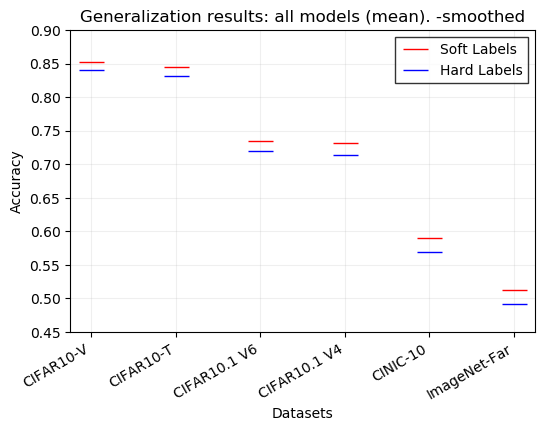

In [161]:
keys = list(C.keys())
print(keys)
accuracy_keys = [x for x in keys if 'acc' in x]
# posh_accuracy_keys = ['CIFAR10 Validation (10k)', 'CIFAR10H Validation (10k)', 'CIFAR10 Training (50k)', 'CIFAR10.1 V6 (2k)', 'CIFAR10.1 V4 (2k)', 'CINIC-10 (210k)', 'ImageNet 32x32 (64k)']
posh_accuracy_keys = [
    'CIFAR10-V', 
    'CIFAR10-T', 
    'CIFAR10.1 V6', 
    'CIFAR10.1 V4', 
    'CINIC-10', 
    'ImageNet-Far']
print(accuracy_keys)
loss_keys = [x for x in keys if 'loss' in x]
print(loss_keys)

#for model in models:
 #   plt.figure()
 #   human_data = H.loc[model , accuracy_keys].squeeze().as_matrix()
 #   control_data = C.loc[model , accuracy_keys].squeeze().as_matrix()
 #   plt.title(model)
 #   plt.ylabel('Accuracy')
 #   plt.xlabel('Datasets')
 #   plt.xticks(np.arange(human_data.shape[0]), accuracy_keys, ha='right', rotation=30)
#    plt.ylim([0.4, 1])
#    plt.plot(human_data, 'r', label='human', marker = '_', linewidth = 0, markersize = 8)
#    plt.plot(control_data, 'b', label='control', marker = '_', linewidth = 0, markersize = 8)
#    plt.legend(fancybox=False)
    
plt.figure(dpi=100)
human_data = H_all.loc[:, accuracy_keys].squeeze().as_matrix()
human_error = H_sem.loc[:, accuracy_keys].squeeze().as_matrix()
print(human_error)
control_data = C_all.loc[:, accuracy_keys].squeeze().as_matrix()
control_error = C_sem.loc[:, accuracy_keys].squeeze().as_matrix()
plt.title('Generalization results: all models (mean). {0}-smoothed'.format(smoothing))
plt.ylabel('Accuracy')
plt.xlabel('Datasets')
plt.xticks(np.arange(human_data.shape[0]), posh_accuracy_keys, ha='right', rotation=30)
plt.ylim([0.45, 0.9])
markers, caps, bars = plt.errorbar(np.arange(human_data.shape[0]), human_data, yerr=human_error,
             c='r', ecolor='r', elinewidth=19, label='Soft Labels', marker = '_', linestyle='None', markersize = 18)


[bar.set_alpha(0) for bar in bars]

markers, caps, bars = plt.errorbar(np.arange(human_data.shape[0]), control_data, yerr=control_error, 
             c='b', elinewidth=19, label='Hard Labels', marker = '_', linestyle='None', markersize = 18)

[bar.set_alpha(0) for bar in bars]

plt.grid(alpha=0.2)
plt.legend(fancybox=False, edgecolor='black')
plt.savefig('figures/accuracy_{0}.pdf'.format(smoothing), bbox_inches='tight')
plt.savefig('figures/accuracy_{0}.png'.format(smoothing), bbox_inches='tight')

[ 0.03829076  0.03912661  0.05650661  0.05640491  0.05096025  0.05579895]


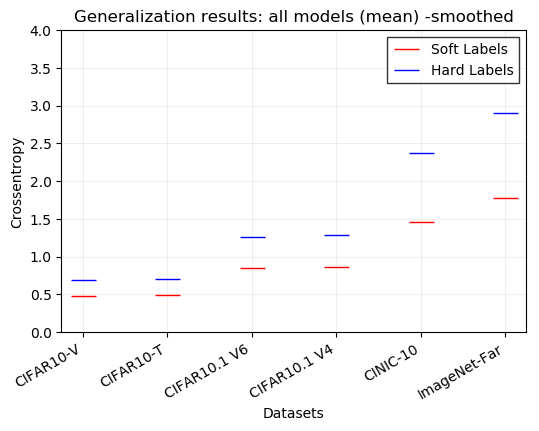

In [162]:
# for model in models:
#     plt.figure()
#     human_data = H.loc[model , loss_keys].squeeze().as_matrix()
#     control_data = C.loc[model , loss_keys].squeeze().as_matrix()
#     plt.title(model)
#     plt.ylabel('Loss')
#     plt.xlabel('Datasets')
#     plt.xticks(np.arange(human_data.shape[0]), loss_keys, ha='right', rotation=30)
#     plt.ylim([0, 4])
#     plt.plot(human_data, 'r', label='human', marker = '_', linewidth = 0, markersize = 8)
#     plt.plot(control_data, 'b', label='control', marker = '_', linewidth = 0, markersize = 8)
#     plt.legend()
    
plt.figure(dpi=100)
human_data = H_all.loc[:, loss_keys].squeeze().as_matrix()
human_error = H_sem.loc[:, loss_keys].squeeze().as_matrix()
print(human_error)
control_data = C_all.loc[:,loss_keys].squeeze().as_matrix()
control_error = C_sem.loc[:, loss_keys].squeeze().as_matrix()
plt.title('Generalization results: all models (mean) {0}-smoothed'.format(smoothing))
plt.ylabel('Crossentropy')
plt.xlabel('Datasets')
plt.xticks(np.arange(human_data.shape[0]), posh_accuracy_keys, ha='right', rotation=30)
plt.ylim([0, 4])
markers, caps, bars = plt.errorbar(np.arange(human_data.shape[0]), human_data, yerr=human_error,
             c='r', ecolor='r', elinewidth=19, label='Soft Labels', marker = '_', linestyle='None', markersize = 18)


[bar.set_alpha(0) for bar in bars]

markers, caps, bars = plt.errorbar(np.arange(human_data.shape[0]), control_data, yerr=control_error, 
             c='b', elinewidth=19, label='Hard Labels', marker = '_', linestyle='None', markersize = 18)

[bar.set_alpha(0) for bar in bars]
plt.grid(alpha=0.2)
plt.legend(fancybox=False, edgecolor='black')

plt.savefig('figures/crossentropy_{0}.pdf'.format(smoothing), bbox_inches='tight')
plt.savefig('figures/crossentropy_{0}.png'.format(smoothing), bbox_inches='tight')

In [163]:
human_files = [x + '_False.npz' for x in models]
human_files.sort()
print(human_files)
#test_files = sort(human)
#print(test_files)
#test_files.remove('resnet_preact_bottleneck_164_test.npz')
#print(test_files)

human_dict = collections.OrderedDict()
for m in human_files:
    raw = np.load('{0}/{1}'.format(loadDir, m))
    model = m.split('.')[0]
    human_dict[model] = {}
    for prop in raw.keys(): 
        human_dict[model][prop] = raw[prop]
print(human_dict.keys())

['densenet_BC_100_12_False.npz', 'pyramidnet_basic_110_270_False.npz', 'resnet_basic_110_False.npz', 'resnet_preact_bottleneck_164_False.npz', 'resnext_29_8x64d_False.npz', 'shake_shake_26_2x64d_SSI_cutout16_False.npz', 'vgg_15_BN_64_False.npz', 'wrn_28_10_False.npz']
odict_keys(['densenet_BC_100_12_False', 'pyramidnet_basic_110_270_False', 'resnet_basic_110_False', 'resnet_preact_bottleneck_164_False', 'resnext_29_8x64d_False', 'shake_shake_26_2x64d_SSI_cutout16_False', 'vgg_15_BN_64_False', 'wrn_28_10_False'])


In [164]:
control_files = [x + '_True.npz' for x in models]
print(control_files)
control_files.sort()
control_dict = collections.OrderedDict()
for m in control_files:
    raw = np.load('{0}/{1}'.format(controlDir, m))
    model = m.split('.')[0]
    control_dict[model] = {}
    for prop in raw.keys(): 
        control_dict[model][prop] = raw[prop]
print(control_dict.keys())

['densenet_BC_100_12_True.npz', 'resnet_preact_bottleneck_164_True.npz', 'shake_shake_26_2x64d_SSI_cutout16_True.npz', 'wrn_28_10_True.npz', 'pyramidnet_basic_110_270_True.npz', 'resnet_basic_110_True.npz', 'vgg_15_BN_64_True.npz', 'resnext_29_8x64d_True.npz']
odict_keys(['densenet_BC_100_12_True', 'pyramidnet_basic_110_270_True', 'resnet_basic_110_True', 'resnet_preact_bottleneck_164_True', 'resnext_29_8x64d_True', 'shake_shake_26_2x64d_SSI_cutout16_True', 'vgg_15_BN_64_True', 'wrn_28_10_True'])


In [165]:
accuracies = []
sbas = []
i_sbas = []
c_sbas = []
b_sbas = []
top_2 = []
top_5 = []
for model, value in human_dict.items():
    print(model)

    humans = value['labels']
    print(humans.shape)
    humans_val = humans.copy()
    print(humans_val.shape)
    model_val = value['probs'].copy()
    print(model_val.shape)
    value['scores'] = get_model_scores(model_val, 
                                       humans_val)
    for k, v in value['scores'].items():
        print(k, v)
        
    accuracies.append(value['scores']['mean_accuracy'].copy())
    top_2.append(value['scores']['top_2'])
    top_5.append(value['scores']['top_5'])
    sbas.append(value['scores']['total_sba'].copy())
    i_sbas.append(value['scores']['incorrect_sba'].copy())
    c_sbas.append(value['scores']['correct_sba'].copy())
    b_sbas.append(value['scores']['best_sba'].copy())

densenet_BC_100_12_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8346
top_2 0.8885
top_3 0.9092
top_4 0.9212
top_5 0.9321
total_sba 0.257
best_sba 0.3392
correct_sba 0.292954708843
incorrect_sba 0.572551390568
pyramidnet_basic_110_270_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8763
top_2 0.9231
top_3 0.937
top_4 0.9442
top_5 0.9514
total_sba 0.2821
best_sba 0.3458
correct_sba 0.311765377154
incorrect_sba 0.586903799515
resnet_basic_110_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8056
top_2 0.8663
top_3 0.8867
top_4 0.9016
top_5 0.9148
total_sba 0.2509
best_sba 0.3411
correct_sba 0.293073485601
incorrect_sba 0.54012345679
resnet_preact_bottleneck_164_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8544
top_2 0.9055
top_3 0.9227
top_4 0.9325
top_5 0.9426
total_sba 0.2686
best_sba 0.3423
correct_sba 0.30079588015
incorrect_sba 0.585851648352
resnext_29_8x64d_False
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8115
top_2 0.8687
top_3

In [166]:
    
print(humans[:2])

[[ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.02        0.89999998  0.          0.08        0.
   0.          0.          0.        ]]


In [167]:
accuracies_post = []
sbas_post = []
i_sbas_post = []
c_sbas_post = []
b_sbas_post = []
top_2_post = []
top_5_post = []

for model, value in control_dict.items():
    print(model)

    humans = value['labels']
    print(humans.shape)
    
    humans_val = humans.copy()
    print(humans_val.shape)
    model_val = value['probs'].copy()
    print(model_val.shape)
    value['scores'] = get_model_scores(model_val, 
                                       humans_val)
    for k, v in value['scores'].items():
        print(k, v)
        
    accuracies_post.append(value['scores']['mean_accuracy'].copy())
    sbas_post.append(value['scores']['total_sba'].copy())
    i_sbas_post.append(value['scores']['incorrect_sba'].copy())
    c_sbas_post.append(value['scores']['correct_sba'].copy())
    b_sbas_post.append(value['scores']['best_sba'].copy())
    top_2_post.append(value['scores']['top_2'])
    top_5_post.append(value['scores']['top_5'])

densenet_BC_100_12_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8273
top_2 0.8827
top_3 0.9035
top_4 0.9133
top_5 0.9251
total_sba 0.2218
best_sba 0.3061
correct_sba 0.251299407712
incorrect_sba 0.568616097279
pyramidnet_basic_110_270_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8515
top_2 0.8992
top_3 0.9168
top_4 0.9267
top_5 0.9379
total_sba 0.2191
best_sba 0.291
correct_sba 0.243570170288
incorrect_sba 0.562962962963
resnet_basic_110_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8017
top_2 0.8633
top_3 0.8822
top_4 0.8956
top_5 0.9094
total_sba 0.1957
best_sba 0.2889
correct_sba 0.228140202071
incorrect_sba 0.534543620777
resnet_preact_bottleneck_164_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.8429
top_2 0.895
top_3 0.913
top_4 0.9236
top_5 0.9342
total_sba 0.2208
best_sba 0.3004
correct_sba 0.24795349389
incorrect_sba 0.58179503501
resnext_29_8x64d_True
(10000, 10)
(10000, 10)
(10000, 10)
mean_accuracy 0.7957
top_2 0.8548
top_3 0.878

['densenet_BC_100_12', 'resnet_preact_bottleneck_164', 'shake_shake_26_2x64d_SSI_cutout16', 'wrn_28_10', 'pyramidnet_basic_110_270', 'resnet_basic_110', 'vgg_15_BN_64', 'resnext_29_8x64d']
8 8
['DenseNet', 'PyramidNet', 'ResNet', 'ResNet Pre-act', 'ResNext', 'Shake Shake', 'VGG', 'Wide ResNet']


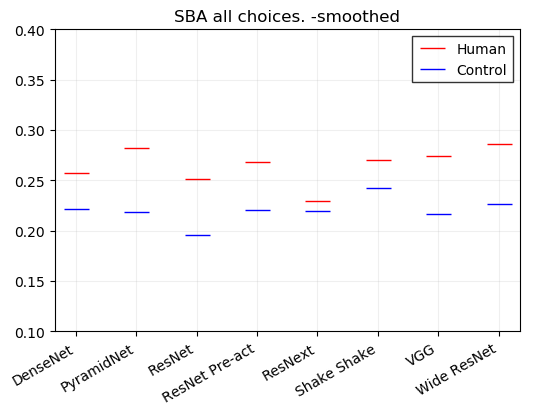

In [168]:
models_new = models.copy()
print(models_new)
print(len(models_new), len(accuracies))

models_new = ['VGG', 'DenseNet', 'PyramidNet', 'ResNet', 'Wide ResNet', 
              'ResNext', 'ResNet Pre-act', 'Shake Shake']
models_new.sort()
print(models_new)
plt.figure(dpi=100)
plt.title('SBA all choices. {0}-smoothed'.format(smoothing))
plt.ylim([0.1, 0.4])
plt.plot(models_new, sbas, 'r', label='Human', marker='_', linewidth=0, markersize = 18)
plt.plot(models_new, sbas_post, 'b', label='Control', marker='_', linewidth=0, markersize = 18)
plt.xticks(rotation=30, ha='right')

plt.grid(alpha=0.2)
plt.legend(fancybox=False, edgecolor='black')

np.mean(np.array(sbas) - np.array(sbas_post))
plt.savefig("figures/SBA_{0}.pdf".format(smoothing), bbox_inches='tight')
plt.savefig("figures/SBA_{0}.png".format(smoothing), bbox_inches='tight')

In [169]:
#plt.figure()
#plt.title('SBA correct first choice')
#plt.ylim([0, 1])
#plt.plot(models_new, c_sbas, 'r', marker='_', linewidth=0)
#plt.plot(models_new, c_sbas_post, 'b', marker='_', linewidth=0)
#plt.xticks(rotation=70, ha='right')

#np.mean(np.array(c_sbas) - np.array(c_sbas_post))

#plt.figure()
#plt.title('SBA incorrect first choice')
#plt.ylim([0, 1])
#plt.plot(models_new, i_sbas, 'r', marker='_', linewidth=0)
#plt.plot(models_new, i_sbas_post, 'b', marker='_', linewidth=0)
#plt.xticks(rotation=70, ha='right')
#np.mean(np.array(i_sbas) - np.array(i_sbas_post))

#plt.figure()
#plt.title('SBA incorrect + correct choices')
#plt.ylim([0, 1])
#plt.plot(models_new, sbas, 'r', marker='_', linewidth=0)
#plt.plot(models_new, sbas_post, 'b', marker='_', linewidth=0)
#plt.xticks(rotation=70, ha='right')
#np.mean(np.array(b_sbas) - np.array(b_sbas_post))


#plt.figure()
#plt.title('Top 2')
#plt.ylim([0, 1])
#plt.plot(models_new, top_2, 'r', marker='_', linewidth=0)
#plt.plot(models_new, top_2_post, 'b', marker='_', linewidth=0)
#plt.xticks(rotation=70, ha='right')
#np.mean(np.array(b_sbas) - np.array(b_sbas_post))


#plt.figure()
#plt.title('Top 5')
#plt.ylim([0, 1])
#plt.plot(models_new, top_5, 'r', marker='_', linewidth=0)
#plt.plot(models_new, top_5_post, 'b', marker='_', linewidth=0)
#plt.xticks(rotation=70, ha='right')
#np.mean(np.array(b_sbas) - np.array(b_sbas_post))